# Ensemble Methods for Regression

In the previous lesson, we learned how to choose between competing machine learning models. However, it is usually better to combine the predictions from the models than to use the prediction from the single best model. This lesson describes methods for combining predictions from different regression models. Methods for combining predictions from different machine learning models are called _ensemble methods_.

In [1]:
import pandas as pd
data_dir = "http://dlsun.github.io/pods/data/"
df_housing = pd.read_csv(data_dir + "AmesHousing.txt", sep="\t")

X_train = df_housing[["Gr Liv Area", "Bedroom AbvGr", "Full Bath"]]
y_train = df_housing["SalePrice"]

First, we fit two models to predict house price: a linear regression model and a $10$-nearest neighbors model.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Train linear regression model
linear_model = LinearRegression()
linear_model.fit(X=X_train, y=y_train)

# Train 10-nearest neighbors model
knn_model = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=10)
)
knn_model.fit(X=X_train, y=y_train)

# Predict for a 1500 sqft, 2BR/2BA house
new_house = [[1500, 2, 2]]
linear_model.predict(new_house), knn_model.predict(new_house)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(array([217919.89318936]), array([220959.]))

The $k$-nearest neighbors model is more optimistic than the linear regression model. How should we combine these two predictions?

## Voting

The simplest ensemble method is _voting_. To apply voting to regression models, we simply average the predictions from the different models. So the predicted quality of the 1990 vintage is:

In [3]:
import numpy as np
np.mean([
    linear_model.predict(new_house),
    knn_model.predict(new_house)
])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


219439.4465946817

We can also specify the voting ensemble in scikit-learn, using `VotingRegressor`.

In [4]:
from sklearn.ensemble import VotingRegressor

ensemble_model = VotingRegressor([
    ("linear", linear_model), 
    ("knn", knn_model)
])
ensemble_model.fit(X=X_train, y=y_train)
ensemble_model.predict(new_house)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([219439.44659468])

How good is this ensemble model? Is it better than each model individually? We let cross-validation decide.

In [5]:
from sklearn.model_selection import cross_val_score

for model in [linear_model, knn_model, ensemble_model]:
    print(-cross_val_score(model, X=X_train, y=y_train, cv=5,
                           scoring="neg_mean_squared_error").mean())

2694147782.5379295
2435815250.2684946
2405095891.177679


Remember that these errors are large because the metric is the mean *squared* error (MSE). To obtain a more interpretable metric, we can take the square root to obtain the RMSE. However, for the purposes of determining which model is best, we just need to know which value is smallest. The ensemble model has a lower MSE than either model individually, even though it simply averages the predictions from the two models. This example illustrates the power of ensembling.

## Stacking

In voting, every model's prediction gets equal weight (or at least a predefined weight, which can be specified using the `weights=` parameter of `VotingRegressor`). Another approach, called _stacking_ , learns the weights $c_1, \ldots, c_M$ given to each of the $M$ models so that the predicted label 

$$ \hat y = c_1 \hat y_1 + \ldots + c_M \hat y_M $$

is as close to the true label as possible. 

We already know how to fit a model of this form. We fit linear regression to predict the same label $y$, but the features are now the predictions $\hat y_1, \ldots, \hat y_M$ from the individual models. 

For example, to learn the weights that should be given to the linear regression and 10-nearest neighbors models above, we first stack the predictions into an array with two columns.

In [6]:
preds = np.stack([
    linear_model.predict(X_train), knn_model.predict(X_train)
], axis=1)
preds

array([[179976.84549368, 161120.        ],
       [119672.36873575, 108065.        ],
       [141137.57264119, 135475.        ],
       ...,
       [ 98497.51467775, 121290.        ],
       [178228.21435129, 134590.        ],
       [247342.99092085, 258969.        ]])

Now, we train a linear regression model on these predictions.

In [7]:
stacker = LinearRegression()
stacker.fit(X=preds, y=y_train)

LinearRegression()

The description of stacking above, while conceptually correct, is not quite accurate. In practice, to prevent overfitting, each prediction in `preds` is calculated using a model that was trained on different data. This can be accomplished using an approach similar to cross-validation, but the details are beyond the scope of this book. Fortunately, scikit-learn handles most of the details.

In [8]:
from sklearn.ensemble import StackingRegressor

stacking_model = StackingRegressor([
    ("linear", linear_model), 
    ("knn", knn_model)],
    final_estimator=LinearRegression()
)
stacking_model.fit(X=X_train, y=y_train)

stacker = stacking_model.final_estimator_
stacker.intercept_, stacker.coef_

(262.6598429933365, array([0.29763825, 0.70197637]))

In other words, the combined prediction is

$$ \widehat{\text{SalePrice}} = 290.5 + 0.30 \cdot (\text{linear regression prediction}) + 0.70 \cdot (\text{$10$-nearest neighbors prediction}). $$

Contrast this with voting, which gave equal weight (i.e., $0.50$) to the two predictions.

How well does stacking do? Again, we use cross-validation to evaluate.

In [9]:
-cross_val_score(stacking_model, X=X_train, y=y_train, cv=5,
                 scoring="neg_mean_squared_error").mean()

2388740364.258189

This is the best model we've seen so far. The error is even lower than the voting ensembler.

## Some Intuition for Ensemble Methods

Why do ensemble methods work so well? Let's consider a model with just one feature.

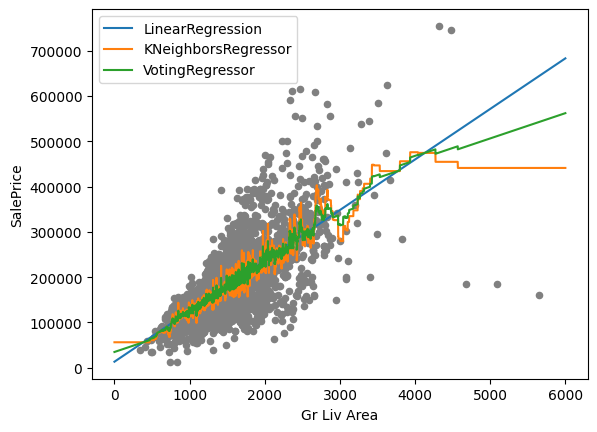

In [10]:
df_housing.plot.scatter(x="Gr Liv Area", y="SalePrice", color="gray")

X_train = df_housing[["Gr Liv Area"]]
y_train = df_housing["SalePrice"]

for model in [LinearRegression(), 
              KNeighborsRegressor(n_neighbors=10), 
              ensemble_model]:
    model.fit(X=X_train, y=y_train)
    X_test = pd.DataFrame({"Gr Liv Area": np.arange(6000)})
    predictions = pd.Series(
        model.predict(X_test),
        index=X_test["Gr Liv Area"]
    )
    predictions.plot.line(legend=True, label=type(model).__name__)

We see that the ensemble model combines the best features of $k$-nearest neighbors and linear regression.

- Like $k$-nearest neighbors, it is able to model nonlinear relationships (such as the pattern near 3000 sqft).
- Like linear regression, it is able to extrapolate near the boundaries of the data range. (Contrast this with $k$-nearest neighbors, which produces predictions that are constant near the boundaries.)

This is why the ensemble model is often superior to each model individually.

## Exercises

Exercise 1-2 asks you to use the tips data set (http://dlsun.github.io/pods/data/tips.csv ).

1\. In Chapter 5.1, you trained a linear regression model to predict the tip from the gender, day of the week, and the total bill. In Chapter 5.2, you trained a $k$-nearest neighbors model to do the same. (In Chapter 5.6, you determined the optimal value of $k$.) Combine these two models using voting. Is the ensemble method better than each method individually?

2\. Now combine the two models using stacking. How does stacking compare to voting?